In [ ]:
# System and other standard libraries
import pickle
import os
import random
import sys
import time
import re
import json
from pathlib import Path

# Data processing, metrics and plot libraries
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Custom packages 
from models import linearregression, cnn, tcn, mlp, lstm, transformer
from utils import scaler
from utils.potsimloader import potsimloader as psl
from utils.preprocessing import process_data

# Pytorch and related libraries
import torch

# Enabling polars global string cache, for more informaiton read below:
# https://docs.pola.rs/api/python/stable/reference/api/polars.StringCache.html
pl.enable_string_cache()

In [ ]:
def set_seed(seed):
    random.seed(seed)  # Set seed for Python's random module
    np.random.seed(seed)  # Set seed for NumPy
    
    # Setting seed for PyTorch devices
    torch.manual_seed(seed)  # For CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # For current GPU (if using CUDA)
set_seed(42)

In [ ]:
# Setting device type to be trained as "cuda" if aviablable else "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Used to combine the yearly data from Dataverse into a 
# single complete file with '.parquet' extension named 
# 'potsim.parquet', saved to 'data' folder of the main directory
def join_potsim_yearly(data_dir, save_dir=Path("data"), save=True):
    if not save:
        return
    data_dir = Path(data_dir).resolve()
    files = os.listdir(data_dir)
    pattern = re.compile(r"^potsim_\d{4}\.parquet$")
    files = sorted([file for file in files if pattern.match(file)])
    files = [data_dir / file for file in files]
    df = pl.scan_parquet(files)
    filepath = save_dir / "potsim.parquet"
    df.sink_parquet(
        filepath,
        statistics=True,
        compression="zstd",
        compression_level=1,
        row_group_size=1_000_000,
    )

# For our training we only need data from one day before the first 
# application of fertilizer i.e. `Npre` or `Npl`. So, we create a 
# `mask` to filter the data later.
mask = (
    ((pl.col("NFirstApp") == "Npl") & (pl.col("DayAfterPlant") >= -1)) |
    ((pl.col("NFirstApp") == "Npre") & (pl.col("DayAfterPlant") >= -37))
)

In [ ]:
# Defining filepaths for all the data files
potsim_yearly_dir = Path("data/potsim_yearly")
weather_file = Path("data") / "weather.parquet"
data_file = Path("data") / "potsim.parquet"

# Change save=False if yearly potsim data already combined
join_potsim_yearly(potsim_yearly_dir, save_dir=Path("data"), save=True)

In [ ]:
# Reads the combined `potsim.parquet` data and joins it with weather 
# data (if provided), then return a polars LazyFrame. 
data = psl.read_data(
    dataset_path=data_file,
    weather_path=weather_file,
    lazy=True,
    as_pandas=False,
)

#### Model Configuration and Feature Selection
This section configures the target variable and associated features for model training using a centralized configuration approach.

**Configuration Management:**
- All experimental configurations are defined in `utils/config.json`
- Change `target_col` to experiment with different prediction targets
- `feature_cols` are read directly from the configuration file at `utils/config.json`
- Adjust `seq_len` based on your temporal model requirements and data characteristics

In [ ]:
# Select target variable for plotting
target_col = "NTotL1"

# Load experiment configuration from config file
# All target variables and their associated features are predefined in config.json
with open(Path("utils/config.json"), 'r') as file:
    metadata = json.load(file).get(target_col)
feature_cols = metadata["features"]

# Sequence length configuration:
# - Set to None for non-sequential models (LinearRegression, MLP, etc.)
# - Set to integer for sequential models (CNN, TCN, LSTM, etc.)
# seq_len = None  # For non-sequential models
seq_len = 15

# Model state and scaler save paths
# For paper experiments: default is "saves" 
# For custom experiments run using example.ipynb: Use default "outputs" 
# or provide other custom path where the model artifacts can be found.
model_save_dir = Path().resolve() / "saves" / f"{target_col}"
scaler_path= model_save_dir / f"{target_col}_scaler.pkl"

In [ ]:
# params_linear = metadata['models']["Linear Regression"].get("params")
# model_linear = linearregression.LinearRegression(**params_linear)
# model_state = model_save_dir / f"{target_col}_LinearRegression.pth"
# model_linear.load_state_dict(torch.load(model_state_linear, weights_only=True))
# model_linear.to(device)
# model_linear.eval()

params_mlp = metadata['models']["Multi-Layered Perceptron"].get("params")
model_mlp = mlp.MLP(**params_mlp)
model_state_mlp = model_save_dir / f"{target_col}_MLP.pth"
model_mlp.load_state_dict(torch.load(model_state_mlp, weights_only=True))
model_mlp.to(device)
model_mlp.eval()

# params_cnn = metadata['models']["1-D Convolutional Neural Network"].get("params")
# model_cnn = cnn.CNN1D(**params_cnn)
# model_state_cnn = model_save_dir / f"{target_col}_CNN1D.pth"
# model_cnn.load_state_dict(torch.load(model_state_cnn, weights_only=True))
# model_cnn.to(device)
# model_cnn.eval()

# params_tcn = metadata['models']["Temporal Convolutional Network"].get("params")
# model_tcn = tcn.TCN(**params_tcn)
# model_state_tcn = model_save_dir / f"{target_col}_TCN.pth"
# model_tcn.load_state_dict(torch.load(model_state_tcn, weights_only=True))
# model_tcn.to(device)
# model_tcn.eval()

params_lstm = metadata['models']["Long Short-Term Memory"].get("params")
model_lstm = lstm.LSTM(**params_lstm)
model_state_lstm = model_save_dir / f"{target_col}_LSTM.pth"
model_lstm.load_state_dict(torch.load(model_state_lstm, weights_only=True))
model_lstm.to(device)
model_lstm.eval()

# params_transformer = metadata['models']["Transformer"].get("params")
# model = transformer.EncoderOnlyTransformer(**params_transformer, max_seq_len=seq_len)
# model_state = model_save_dir / f"{target_col}_EncoderOnlyTransformer.pth"
# model_trs.load_state_dict(torch.load(model_state_trs, weights_only=True))
# model_trs.to(device)
# model_trs.eval()
print("All models loaded successfully")

All models loaded successfully


In [ ]:
def get_prediction(mdl, _data, feature_cols, target_col, device, 
                         scaler_path, seq_len=None):
    """Generate predictions using a trained model on new data.
    Args:
        mdl: Trained PyTorch model
        _data: Input dataframe with features
        feature_cols: List of feature column names
        target_col: Target variable name (for scaler reference)
        device: PyTorch device (CPU/GPU)
        scaler_path: Path to fitted scaler for data preprocessing
        seq_len: Sequence length for temporal models (None for non-sequential)
    Returns:
        numpy array of predictions in original scale
    """
    X, _ = process_data(_data, feature_cols, target_col, scaler_path=scaler_path, 
                                    mode="transform", seq_len=seq_len)
    X_tensor = torch.FloatTensor(X).to(device)
    with torch.inference_mode():
        y_pred = mdl(X_tensor)
    y_pred = y_pred.cpu().numpy().flatten()
    y_pred = scaler.inverse_normalize(y_pred, target_col, scaler_path=scaler_path)
    return y_pred

In [ ]:
def plot_napp_markers(_data, first_app, _ax):
    """Plot nitrogen application markers on a time series plot.
    Args:
        _data: DataFrame containing crop data with 'DayAfterPlant' and N application info
        first_app: Type of first nitrogen application ('Npl' or 'Npre')
        _ax: Matplotlib axis object to plot on
    """
    napp_markers = {22: 'Nemg', 44: 'Ntu'}
    if first_app == "Npl":
        napp_markers[0] = 'Npl'
    if first_app == "Npre":
        napp_markers[-36] = "Npre"
    for day, label in napp_markers.items():
        napp_row = _data[_data['DayAfterPlant'] == day]
        if not napp_row.empty:
            # Only mark if there was an application
            # napp_value = napp_row['NApp'].values[0]
            # if napp_value > 0:
            _ax.axvline(x=day, color='green', linestyle='dotted', alpha=0.8, linewidth=1.5)
            _ax.plot(day, 0, marker='v', color='green', markersize=7)
            _ax.text(day, 0.95, label, color='green', ha='center', fontsize=9, 
                    fontweight='bold', transform=ax.get_xaxis_transform())
            
def get_caption(target_cols, selected_scenarios):
    """ Generate a descriptive caption for visualization plots based on scenario parameters.
    """
    caption_text = "\n"
    for k, v in selected_scenarios.items():
        if not isinstance(v, list) or len(v) == 1:
            caption_text += f"{k}={v} "
    caption_text = f'This visualization shows {target_col} patterns over time for different treatments with {caption_text}'
    return caption_text

In [ ]:
# Example y_pred for plotting, copy and replace as needed.
# y_pred_linear = get_prediction(model_linear, subset, feature_cols, target_col, device, scaler_path, seq_len=None)
# y_pred_mlp = get_prediction(model_mlp, subset, feature_cols, target_col, device, scaler_path, seq_len=None)
# y_pred_cnn = get_prediction(model_cnn, subset, feature_cols, target_col, device, scaler_path, seq_len=seq_len)
# y_pred_tcn = get_prediction(model_tcn, subset, feature_cols, target_col, device, scaler_path, seq_len=seq_len)
# y_pred_lstm = get_prediction(model_lstm, subset, feature_cols, target_col, device, scaler_path, seq_len=seq_len)
# y_pred_transformer = get_prediction(model_transformer, subset, feature_cols, target_col, device, scaler_path, seq_len=seq_len)

### Example-1
#### Out of 6 scenarios, let's consider multiple possibilites for only one scenario-"Treatment" and plot how two models (MLP and LSTM) predict the same variable-Leaching (NLeach). 


In [122]:
selected_scenarios = {
    "Year": 2023,
    "Treatment": ["56-168-112", "56-112-196", "168-56-112", "196-56-56"],
    "PlantingDay": 43,
    "IrrgDep": 30,
    "IrrgThresh": 70,
    "NFirstApp": "Npl"
}

In [123]:
scenario_cols = set(selected_scenarios.keys())
usecols = scenario_cols.union(set(["DayAfterPlant", "NApp", target_col] + feature_cols))
df = psl.apply_filter(data.select(usecols), filters=selected_scenarios, lazy=True, as_pandas=False)
df = df.filter(mask).collect().to_pandas()

In [124]:
treatments = df['Treatment'].unique()
ylims = [-3, 26]

### Notes on plots
- brown '^' traingle represents day of planting
- green vertical dashed lines represent day of nitrogen application during the cycle
- for each model, the predicted `y` plots only for the day when prediction starts
- change the `ylims` according to the target to fit the plots

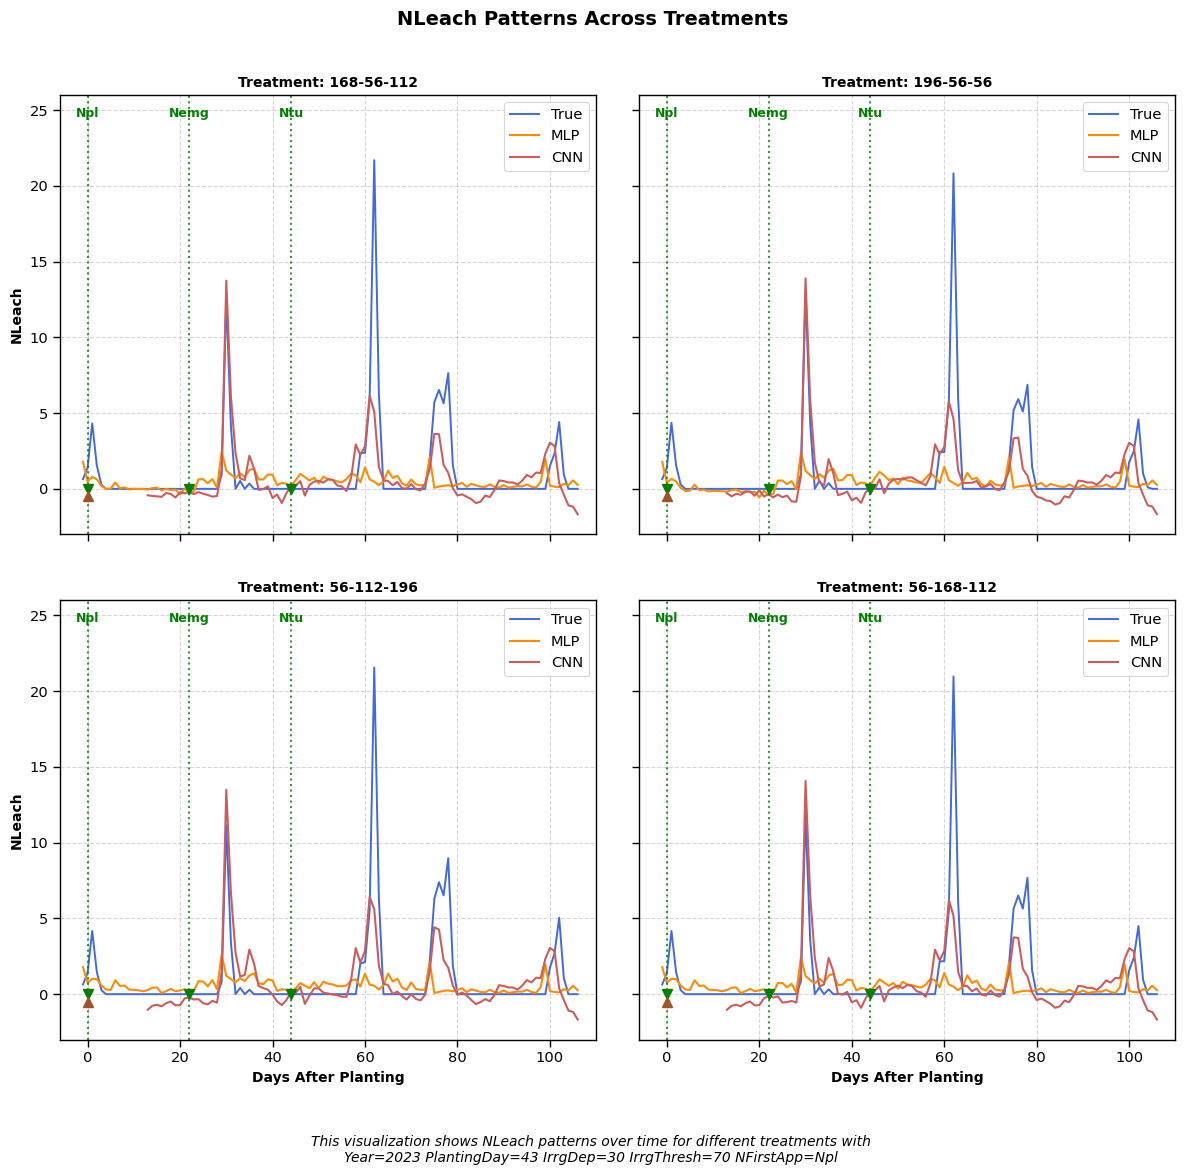

In [ ]:
# plt.style.use('seaborn-v0_8-paper')
sns.set_context("paper", font_scale=1.2)
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)

for i, treatment in enumerate(treatments):
    ax = axes[i // 2, i % 2]
    subset = df[df['Treatment'] == treatment]
    subset = subset.sort_values('DayAfterPlant')

    # Plot target_col vs DayAfterPlant
    x_data = subset['DayAfterPlant']
    y_true = subset[target_col]
    ax.plot(x_data, y_true, label="True", linestyle='-', linewidth=1.4, color="royalblue")
    
    y_pred_mlp = get_prediction(model_mlp, subset, feature_cols, target_col, device,
                           scaler_path, seq_len=None)
    y_pred_lstm = get_prediction(model_lstm, subset, feature_cols, target_col, device,
                           scaler_path, seq_len=seq_len)
    ax.plot(x_data, y_pred_mlp, label="MLP", linestyle='-', linewidth=1.5, color="darkorange")
    ax.plot(x_data[seq_len-1:], y_pred_lstm, label="LSTM", linestyle='-', linewidth=1.5, color="indianred")

    # Plot Nitrogen Fertilizer Application Markers with vertical dashed lines
    plot_napp_markers(subset, selected_scenarios["NFirstApp"], _ax=ax)
    
    # Mark Day of Planting for reference
    ax.plot(0, -0.5, marker='^', color='sienna', markersize=7)

    # Set title and labels
    ax.set_title(f'Treatment: {treatment}', fontweight='bold', fontsize=10)
    ax.legend(frameon=True, facecolor='white', loc='upper right')
    ax.set_ylim(*ylims)
    ax.set_xlim(min(x_data)-5, max(x_data)+4)
    # ax.set_xticks(np.arange(min(min(x_data), -1)+1, max(x_data)+2, 18))
    ax.grid(True, linestyle='--', alpha=0.5)

    # x, y labels on sides
    if (i%2) == 0:
        ax.set_ylabel(target_col, fontweight='bold', fontsize=10)
    if i //2 == 1:
        ax.set_xlabel('Days After Planting', fontweight='bold', fontsize=10)
        

fig.suptitle(f'{target_col} Patterns Across Treatments', fontsize=14, fontweight='bold', y=0.97)
fig.text(0.5, 0.01, get_caption(target_col, selected_scenarios), ha='center', fontsize=10, style='italic')
plt.tight_layout(rect=[0, 0.06, 1, 0.96])
plt.subplots_adjust(hspace=0.15, wspace=0.08)
# plt.savefig(f'plots/{target_col}_treatment.png', dpi=100, bbox_inches='tight')
plt.show()

----

### Example-2
####  Out of 6 scenarios, let's consider multiple possibilites for two scenarios-"Treatment" and "Planting Day". We plot how two models(MLP and LSTM) predict the same variable-Leaching (NLeach). 


In [114]:
selected_scenarios = {
    "Year": [2023],
    "Treatment": ["56-168-112", "56-112-196", "168-56-112"],
    "PlantingDay": [29, 43],
    "IrrgDep": [30],
    "IrrgThresh": [70],
    "NFirstApp": ["Npl"]
}

In [115]:
scenario_cols = set(selected_scenarios.keys())
usecols = scenario_cols.union(set(["DayAfterPlant", "NApp", target_col] + feature_cols))
df = psl.apply_filter(data.select(usecols), filters=selected_scenarios, lazy=True, as_pandas=False)
df = df.filter(mask).collect().to_pandas()

In [116]:
# Get unique pldays and treatments
pldays = sorted(df['PlantingDay'].unique())
treatments = sorted(df['Treatment'].unique())
ylims = [-3, 26]


### Notes

- brown '^' traingle represents day of planting
- green vertical dashed lines represent day of nitrogen application during the cycle
- for each model, the predicted `y` plots only for the day when prediction starts
- change the `ylims` according to the target to fit the plots

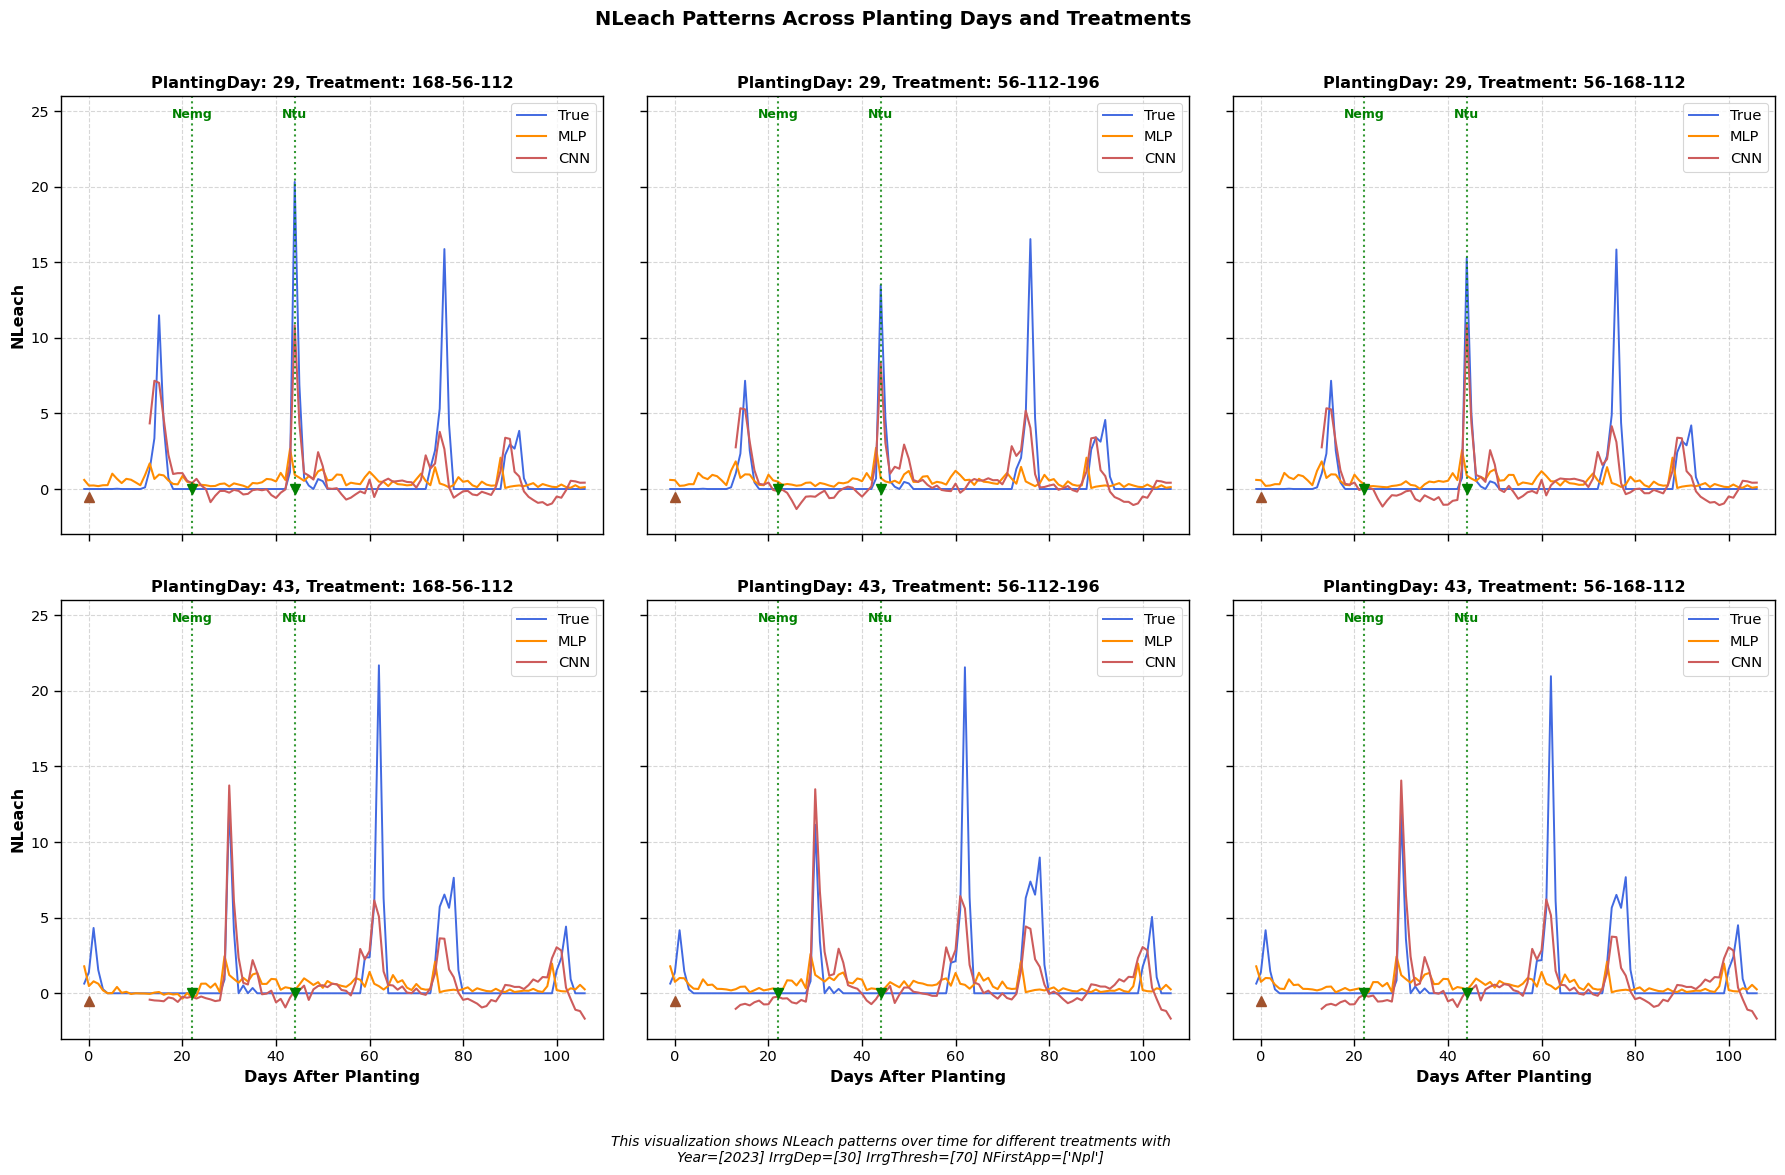

In [ ]:
sns.set_context("paper", font_scale=1.2)
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=True, sharey=True)

# Iterate through each plday-treatment combination
for i, plday in enumerate(pldays):
    for j, treatment in enumerate(treatments):
        ax = axes[i, j]
        subset = df[(df['PlantingDay'] == plday) & (df['Treatment'] == treatment)]
        subset = subset.sort_values('DayAfterPlant')
        
        # Plot target_col vs DayAfterPlant
        x_data = subset['DayAfterPlant']
        y_true = subset[target_col]
        ax.plot(x_data, y_true, label="True", linestyle='-', linewidth=1.4, color="royalblue")
        
        # Get prediction for the model
        # replace the model names accordingly
        y_pred_mlp = get_prediction(model_mlp, subset, feature_cols, target_col, device,
                               scaler_path, seq_len=None)
        y_pred_lstm = get_prediction(model_lstm, subset, feature_cols, target_col, device,
                               scaler_path, seq_len=seq_len)
        ax.plot(x_data, y_pred_mlp, label="MLP", linestyle='-', linewidth=1.5, color="darkorange")
        ax.plot(x_data[seq_len-1:], y_pred_lstm, label="LSTM", linestyle='-', linewidth=1.5, color="indianred")
        
        # Plot Nitrogen Fertilizer Application Markers with vertical dashed lines
        plot_napp_markers(subset, selected_scenarios["NFirstApp"])

        # Mark Day of Planting for reference
        ax.plot(0, -0.5, marker='^', color='sienna', markersize=7)
            
        # Set title and labels
        ax.set_title(f'PlantingDay: {plday}, Treatment: {treatment}', fontweight='bold')
        ax.legend(frameon=True, facecolor='white', loc='upper right')
        ax.set_ylim(*ylims)
        ax.set_xlim(min(x_data)-5, max(x_data)+4)
        # ax.set_xticks(np.arange(min(min(x_data), -1)+1, max(x_data)+1, 20))
        ax.grid(True, linestyle='--', alpha=0.5)

        # x, y labels on sides
        if j == 0:
            ax.set_ylabel(target_col, fontweight='bold')
        if i == 1:
            ax.set_xlabel('Days After Planting', fontweight='bold')
        

fig.suptitle(f'{target_col} Patterns Across Planting Days and Treatments', fontsize=14, fontweight='bold', y=0.97)
fig.text(0.5, 0.01, get_caption(target_col, selected_scenarios), ha='center', fontsize=10, style='italic')
plt.tight_layout(rect=[0, 0.06, 1, 0.96])
plt.subplots_adjust(hspace=0.15, wspace=0.08)
# plt.savefig(f'plots/{target_col}_plantingday_treatment.png', dpi=100, bbox_inches='tight')
plt.show()